In [17]:
from utils import *

In [18]:
directory_path = "./Data/fig14and15"
filenames = os.listdir(directory_path)
# filenames = [filename for filename in filenames if "-d" in filename] # ! NLOS
filenames = [filename for filename in filenames if "-d" not in filename] # ! LOS

data_dict = {}

for filename in filenames:
    if filename == ".DS_Store":
        continue
    start_freq, stop_freq, cd, dwells, angle, distance, index = parse_bin_name(filename)
    gt_freqs = default_theory_freq(filename)
    
    data = parse_csv_file(os.path.join(directory_path, filename))
    # print(gt_slope, start_freq, stop_freq, cd_time, gt_gap_freq)
    key = f"{start_freq}-{angle}-{index}"
    if key not in data_dict:
        data_dict[key] = {"data": data, "gt_freqs": gt_freqs, "CD": cd, "angle": angle, "distance": distance, "filename": filename, "start_freq": start_freq}

print(len(data_dict))

83


In [19]:
los_detection = {}

debug = False

tolerance = 3
delta_L1 = (72 - 3) * 0.0254
delta_L2 = (72 - 48) * 0.0254
delta_L3 = (48 - 3) * 0.0254
expected_ratios = [
    delta_L1 / delta_L3,  # Ratio 1 (L1 to L3)
    delta_L3 / delta_L2,   # Ratio 2 (L3 to L2)
    delta_L1 / delta_L2,   # Ratio 2 (L3 to L2)
]

for data_key in data_dict:
    data_obj = data_dict[data_key]
    timestamp = data_obj['data'][:, 0]
    amplitude = data_obj['data'][:, 1] * 1.0
    fs = len(timestamp) / (timestamp[-1] - timestamp[0])
    distance = data_obj['distance']
    Xs, _ = crop_signal_tolist(amplitude, fs, num_segments = None, crop_factor = 8, plot = debug, window_length = 15, ignore_aperiodic=True)
    for X in Xs:
        peaks, frequency_spectrum = detect_frequency(X, fs, None, signal_count = 3, plot = debug)
        plt.show()
        max_peak_value = np.max(frequency_spectrum)
        peaks, properties = signal.find_peaks(frequency_spectrum, height=max_peak_value/15)  # Adjust height threshold based on noise level

        valid_peak_triplets = []
        peak_amplitudes = properties['peak_heights']
        largest_amplitude_index = np.argmax(peak_amplitudes)
        largest_peak = peaks[largest_amplitude_index]

        best_triplet = None

        min_peak_distance = 1000
        max_amplitude_sum = 0
        for i in range(len(peaks)):
            for j in range(i + 1, len(peaks)):
                for k in range(j + 1, len(peaks)):
                    if peaks[k] > peaks[j] > peaks[i]:
                        if (peaks[j] - peaks[i] < min_peak_distance) or (peaks[k] - peaks[j] < min_peak_distance) or (peaks[k] - peaks[i] < min_peak_distance):
                            continue  # Skip this triplet if any peaks are too close

                        # Calculate ratios between the three peaks
                        ratio_1 = peaks[k] / peaks[j]  # L1 to L3
                        ratio_2 = peaks[j] / (peaks[i] + 200)  # L3 to L2

                        # Check if all ratios match the expected ratios within the tolerance
                        if (
                            abs(ratio_1 - expected_ratios[0]) < tolerance and
                            abs(ratio_2 - expected_ratios[1]) < tolerance
                        ):
                            # if largest_peak in (peaks[i], peaks[j], peaks[k]):
                            amplitude_i = peak_amplitudes[np.where(peaks == peaks[i])[0][0]]
                            amplitude_j = peak_amplitudes[np.where(peaks == peaks[j])[0][0]]
                            amplitude_k = peak_amplitudes[np.where(peaks == peaks[k])[0][0]]

                            amplitude_sum = amplitude_i * amplitude_j * amplitude_k

                            if amplitude_sum > max_amplitude_sum:
                                max_amplitude_sum = amplitude_sum
                                best_triplet = (peaks[i], peaks[j], peaks[k])

        if best_triplet:
            coverage = 1
        else:
            coverage = 0

        if "score" not in data_obj:
            data_obj["score"] = []
        data_obj["score"].append(coverage)

Text(0, 0.5, 'Detection Rate')

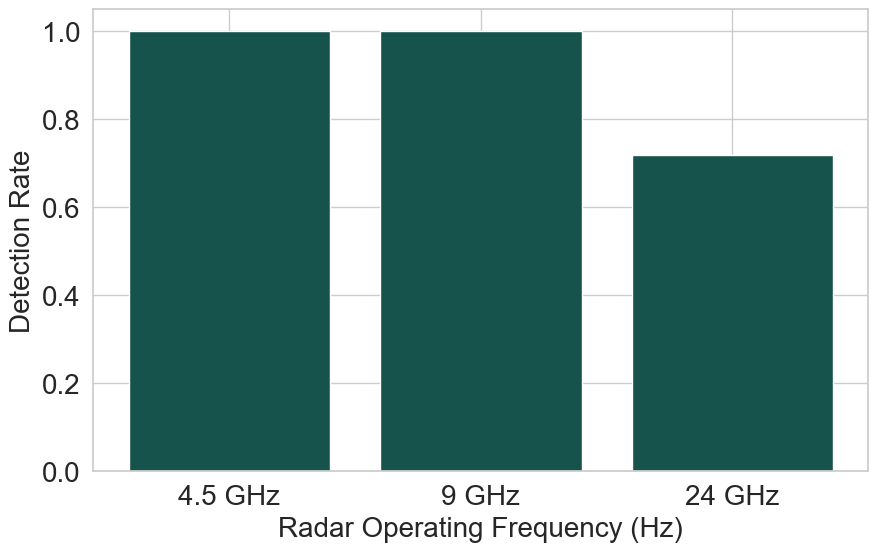

In [20]:
detection_dict = {}
bins = np.array([4.5e3, 9e3, 24e3])
for bin_start in bins:
    detection_dict[bin_start] = {"detected": 0, "total": 0}

for data_obj in data_dict.values():
    start_freq = data_obj['start_freq']
    scores = data_obj['score']
    for score in scores:
        bin_start = bins[np.argmax(start_freq == bins)]
        detection_dict[bin_start]["total"] += 1
        if score >= threshold:
            detection_dict[bin_start]["detected"] += 1
            
import seaborn as sns
color_map = sns.color_palette("cubehelix", 3).as_hex() # !!!! <- COLOR PALLETTE

# Set seaborn style
sns.set(style="whitegrid")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 25
matplotlib.rcParams['lines.linewidth'] = 5

fontsize = 20
matplotlib.rcParams['xtick.labelsize'] = fontsize
matplotlib.rcParams['ytick.labelsize'] = fontsize
matplotlib.rcParams['legend.fontsize'] = fontsize
matplotlib.rcParams['axes.labelsize'] = fontsize

plt.figure(figsize = (10, 6))

baseband_name = {4.5e3: "4.5 GHz", 9e3: "9 GHz", 24e3: "24 GHz"}
# baseband_name = {24e3: "24GHz"}
# Plot in bar
bin_names = [baseband_name[bin_start] for bin_start in bins]
bin_values = [detection_data["detected"] / detection_data["total"] for detection_data in detection_dict.values()]
plt.bar(bin_names, bin_values, color=color_map[0], hatch='')
plt.xlabel("Radar Operating Frequency (Hz)")
plt.ylabel("Detection Rate")
# plt.title("Detection Rate vs Baseband Frequency")